#### The purpose of this notebook is to extract images of panels from images of grids of panels.
#### Procedure:
    1. Import images of grids of solar panels from ./Data/170725_Panel_Grids_EL2.zip
    2. Perform a global histogram equalization.
    3. Threshold the grid of panels.
    4. Crop the image.
    5. Detect the horizontal lagunas between panels.
    6. Use the laguna indices to estimate the panel width.
    7. Use the panel width to estimate indices for the horizontal lagunas between panels.
    8. Use the hor+vert indices to crop and save each panel in the grid.
    9. Save the results to a directory in ./Data, providing a unique identifier for each panel.
    
Note: Detecting the vertical lagunas between panels is not a robust method of estimating their indices, since the panel mullions generate false-positives.

In [1]:
from zipfile import ZipFile
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage.transform import rotate
from skimage.exposure import equalize_hist
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imsave
from scipy.stats import mode
from uuid import uuid4
%matplotlib inline

*Utilities*

In [2]:
def display_image(img):
    """
    Plots a single image, without axes.
    
    Arguments
        img is a 2D np.float32 array
    """
    f = plt.figure(figsize = (15, 7))
    plt.imshow(img, cmap = 'gray');
    return plt.gca()

def dnorm(i, mu, std):
    """
        Returns normal density at i, given mean mu and s.d. std.
    """
    return (1/np.sqrt(2*np.pi*std**2)) * np.exp(-0.5*(i - mu)**2/(std**2))

*Preprocessing steps in order of application*

In [3]:
def dumb_crop(img, thresh_img):
    rows_to_remove = np.prod(thresh_img, axis = 1)
    cols_to_remove = np.prod(thresh_img, axis = 0)

    l_boundary, r_boundary = suppress_central_ix(rows_to_remove, thresh_img.shape[0])
    rows_to_remove[l_boundary:r_boundary] = 0.
    
    t_boundary, b_boundary = suppress_central_ix(cols_to_remove, thresh_img.shape[1])
    cols_to_remove[t_boundary:b_boundary] = 0.
    
    thresh_img = thresh_img[rows_to_remove == 0, :]
    thresh_img = thresh_img[:, cols_to_remove == 0]
    img        = img[rows_to_remove == 0, :]
    img        = img[:, cols_to_remove == 0]
    
    return thresh_img, img


class HoughTransform(object):
    """
        Class to allow fine-grained control over a Hough transform (i.e. at particular radii, angles)
    """
    def __init__(self, angles, radii_bins):
        self.angles = angles
        self.radii_bins  = radii_bins
        self.H = None
    
    def transform(self, binary_image):
        """
            angles in angle_bins are in radians
            radii in radii bins are in image coordinates (origin at center of image frame)

            Configures HoughTransform's 'H' attribute.
            Configures HoughTransform's 'magnitude' attribute.
        """
        # Define basis vectors at defined angular spacing
        U = np.array([np.cos(self.angles), np.sin(self.angles)])
        # ^ Columns are u1, ..., where ui = (cos(theta_i), sin(theta_i))

        # Get cartesian position of non-zero image elements
        C       = np.array(np.nonzero(binary_image), dtype=np.float32) # i, j indices
        C[0, :] = (binary_image.shape[0]/2 - C[0, :])
        C[1, :] = (binary_image.shape[1]/2 - C[1, :])
        C       = np.flip(C, axis = 0) # (y, x) -> (x, y)

        # Project the non-zero elements onto the basis vectors
        R = np.matmul(C.T, U) # R = [r1, ..., rn] where ri is a vector of projection distances at angle i

        # Bin the values in R's columns at the specfied radii
        self.H = np.zeros(shape = [self.radii_bins.shape[0],
                                   self.angles.shape[0]]) # Columns correspond to angles, rows to specfied radii
        for i, radius_i in enumerate(self.radii_bins[:-1]):
                self.H[i, :] = np.sum(np.logical_and(R >= radius_i,
                                                     R < self.radii_bins[i+1]), axis = 0)
        
        # Get radius, angle of strongest response
        peak_ix          = np.nonzero(self.H == np.max(self.H))
        self.peak_angle  = self.angles[peak_ix[1][0]]
        self.peak_radius = self.radii_bins[peak_ix[0][0]]
        
        
def deskew_and_center(image, thresholded_image):
    """
    Deskews and centers a grid of solar panel images.
    
    1. Inverts and thresholds image.
    2. Determines suitable parameters for a Hough transform. (distance from edge, range of angles)
    3. Applies the Hough transform in each direction (N, E, S, W).
    4. Identifies the angle + radial distance that yield a peak.
    5. Aligns the image frame's and grid rectangle's centers.
    6. Rotates the grid.
    
    Sub-functions:
    
    Arguments:
        img is a 2D np.float32 array of a grid of solar panels
    """
    
    # 1. Perform Hough transform (determines bounding perimeter rectangle lines)
    edge_parameters = {'N':[], 'E':[], 'S':[], 'W':[]}
    OFFSET          = {'N':[np.pi/2,  0.5*23*image.shape[0]/24, 0.5*image.shape[0]],
                       'E':[0,        0.5*11*image.shape[1]/12, 0.5*image.shape[1]],
                       'S':[-np.pi/2, 0.5*23*image.shape[0]/24, 0.5*image.shape[0]],
                       'W':[np.pi,    0.5*11*image.shape[1]/12, 0.5*image.shape[1]]}
    # ^ Angular offset, radii lower bound, radii upper bound
    ANGLE_RNG  = np.pi/180      # Max angle amplitude
    ANGLE_RES  = 0.1*ANGLE_RNG # Angular resolution
    
    for edge_key in edge_parameters.keys():
        angles     = np.arange(-ANGLE_RNG + OFFSET[edge_key][0], ANGLE_RNG + OFFSET[edge_key][0], ANGLE_RES)
        radii_bins = np.arange(OFFSET[edge_key][1], OFFSET[edge_key][2], 1)
        ht         = HoughTransform(angles, radii_bins)
        ht.transform(thresholded_image)
        edge_parameters[edge_key] = (ht.peak_angle, ht.peak_radius)
    
    # 2. Center the grid
    delta_y = (edge_parameters['N'][1] - edge_parameters['S'][1])/2
    delta_x = (edge_parameters['E'][1] - edge_parameters['W'][1])/2
    image = np.roll(image, shift = int(delta_x), axis = 1)
    image = np.roll(image, shift = int(delta_y), axis = 0)
    
    # 3. Align the grid
    # Take median angle
    th    = np.median([edge_parameters['N'][0] - np.pi/2,
                       edge_parameters['E'][0] - 0,
                       edge_parameters['S'][0] + np.pi/2,
                       edge_parameters['W'][0] - np.pi])
    th    = th*180/np.pi
    thresholded_image = rotate(thresholded_image, th) # Rotates in counter-clockwise direction - we want to *correct* the skew
    rotated_image     = rotate(image/255, th)
    
    return rotated_image, thresholded_image

def edge_score(image, ax = 1):
    """
        Scores horizontal or vertical lines in an image.
        Computes a 'decaying product':
                prod([1, 1, 1, 1, 0.99, 1, 1, 1, 1, 0.99, ..., 1])
            =   prod([GAMMA**(1-img[0]), GAMMA**(1-img[1]), ... ,  GAMMA**(1-img[N])])
        Then smooths it using a Gaussian filter.
    """

    GAMMA = 0.99
    score = np.prod(GAMMA**(1-image), axis = ax)
    SD    = 5
    score = gaussian_filter(score, SD)
        
    return score

def peak_detector(score, threshold):
    """
        Returns indices corresponding to cluster centers in a 1D series.
        Thresholds, retrieves centroids of sets of contiguous elements.
    """
    score     = score > threshold
    n_points_in_cluster = 0
    index_sum = 0
    cluster_centroids = []
    
    for i in range(score.shape[0]):
        if (score[i] == 1):
            index_sum += i
            n_points_in_cluster += 1
            
        if ((score[i] == 0) or (i+1 == score.shape[0])) and (n_points_in_cluster > 0):
            cluster_centroids.append(int(index_sum/n_points_in_cluster))
            index_sum = 0
            n_points_in_cluster = 0
            
    return np.array(cluster_centroids)


def update_row_ix(row_ix, panel_height):
    """
        Suppresses indices that are unlikely to bound a panel.
        Considers difference between the size of the regions an index bounds, and an estimate of the panel's length.
        If this distance is small, then the index probably does bound a panel.
        If this difference is large, then the index is probably a false-positive and is therefore suppressed.
    """
    retained_ix = [row_ix[0]]
    
    for j in range(1, len(row_ix) - 1):
        if (abs(row_ix[j] - row_ix[j+1] + panel_height) < 10 or
            abs(row_ix[j] - row_ix[j-1] - panel_height) < 10):
                
                retained_ix.append(row_ix[j])
                
    retained_ix.append(row_ix[-1])
    return np.array(retained_ix)


def suppress_central_ix(mask_ix, side):
    """
        mask_ix: [1, 1, 1, 1, 1, 0, 0, , ..., 0, 1, 1, 1, 0, ..., 0, 1, 1, 0, 1, 1, 1, 1, 0]
        
        returns index of      ^                    and                        ^
    """
    for i in range(len(mask_ix)):
        if mask_ix[i] == 0:
            l_boundary = i - 1
        if mask_ix[-i] == 0:
            r_boundary = side - i + 1
        if (mask_ix[i] == 0) and (mask_ix[-i] == 0):
            break
    return l_boundary, r_boundary

In [5]:
counter = 0

_ = True
with ZipFile('./Data/170725_Panel_Grids_EL2.zip', mode = 'r') as grid_archive:
    for filename in grid_archive.infolist():
        with grid_archive.open(filename) as file:
            print('Processing image {}.'.format(counter))
            counter += 1
            if counter >= 76:

                orig_img = Image.open(file).convert('L')
                orig_img = np.array(orig_img.getdata()).reshape(orig_img.size[1],
                                                                orig_img.size[0]).astype(np.float32)

                # 1. Equalize the image (i.e. stretch its intensity distribution)
                equalized_img = equalize_hist(orig_img) # in [0, 1]


                # 2. Threshold in favor of black pixels
                THRESHOLD = 0.4
                thresholded_img  = equalized_img < THRESHOLD

                # 3. Crop the image - remove all border columns/rows that only contain black pixels
                thresholded_img, img = dumb_crop(equalized_img, thresholded_img)

                # 4. Standardize the image's orientation
                if img.shape[0] < img.shape[1]:
                    img = img.T

                # 5. De-skew and center the grid of panels (Apply Hough then affine transform)
                img, thresholded_img = deskew_and_center(img, thresholded_img)

                # 6. Take decaying product along horizontal axis to get horizontal line scores
                #    > Use these scores to estimate panel edge indices
                hor_line_score = edge_score(thresholded_img)
                row_ix         = peak_detector(hor_line_score, 0.01) # Row indices
                panel_height   = mode([row_ix[i] - row_ix[i - 1] for i in range(1, len(row_ix))])[0][0]
                row_ix         = update_row_ix(row_ix, panel_height) # Suppresses false-positives

                grid_width     = thresholded_img.shape[1]
                col_ix         = list(range(0, grid_width - panel_height//2, panel_height)) + [grid_width]   # Column indices
                col_ix         = np.array(col_ix)

                # 7. Extract the panels using the indices corresponding to panel edges
                n_panels = (row_ix.shape[0] - 1) * (col_ix.shape[0] - 1)
                if n_panels > 0:

                    for i in range(row_ix.shape[0]-1):
                        for j in range(col_ix.shape[0]-1):
                            imsave('./Data/170726_Panel_Solos/' + str(counter) + '_' + str(uuid4()) + '.png',
                                    img[row_ix[i]:row_ix[i+1], col_ix[j]:col_ix[j+1]])

            else:
                print('No panels detected @ image number {}, moving on...\n'.format(counter))

Processing image 0.
No panels detected @ image number 1, moving on...

Processing image 1.
No panels detected @ image number 2, moving on...

Processing image 2.
No panels detected @ image number 3, moving on...

Processing image 3.
No panels detected @ image number 4, moving on...

Processing image 4.
No panels detected @ image number 5, moving on...

Processing image 5.
No panels detected @ image number 6, moving on...

Processing image 6.
No panels detected @ image number 7, moving on...

Processing image 7.
No panels detected @ image number 8, moving on...

Processing image 8.
No panels detected @ image number 9, moving on...

Processing image 9.
No panels detected @ image number 10, moving on...

Processing image 10.
No panels detected @ image number 11, moving on...

Processing image 11.
No panels detected @ image number 12, moving on...

Processing image 12.
No panels detected @ image number 13, moving on...

Processing image 13.
No panels detected @ image number 14, moving on..

#### Results

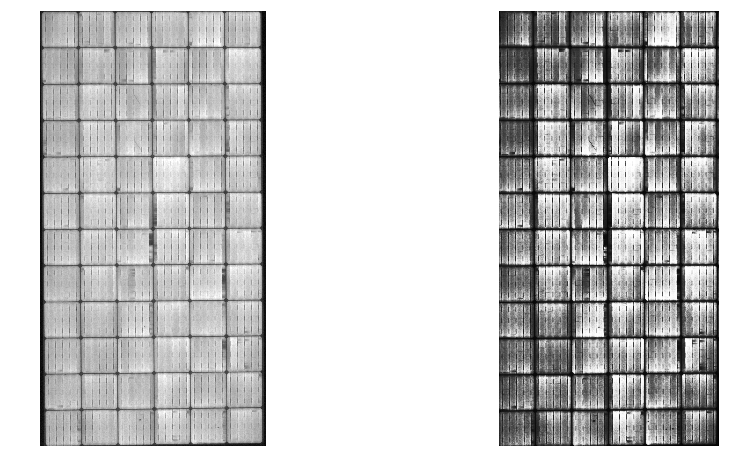

In [90]:
f, ax = plt.subplots(1, 2, figsize = (15, 8))
ax[0].imshow(orig_img, cmap = 'gray'); ax[0].axis('off')
#ax[0].set_title('Original grid of panels');

ax[1].imshow(img, cmap = 'gray'); ax[1].axis('off')
#ax[1].set_title('Equalized and deskewed grid of panels');
plt.savefig('panel_extractor_preprocessing.pdf')

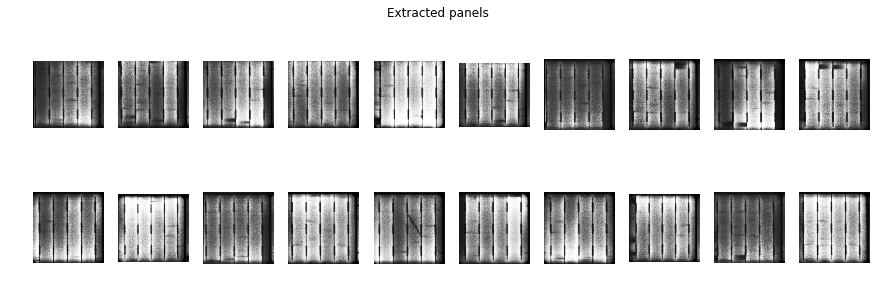

In [91]:
f, axs = plt.subplots(2, 10, figsize = (15, 4.5))
for i, ax in enumerate(axs.flat):
    ax.imshow(panels[i], cmap = 'gray');
    ax.axis('off');
f.suptitle('Extracted panels');
plt.savefig('panel_extractor_extracted_panels.pdf')

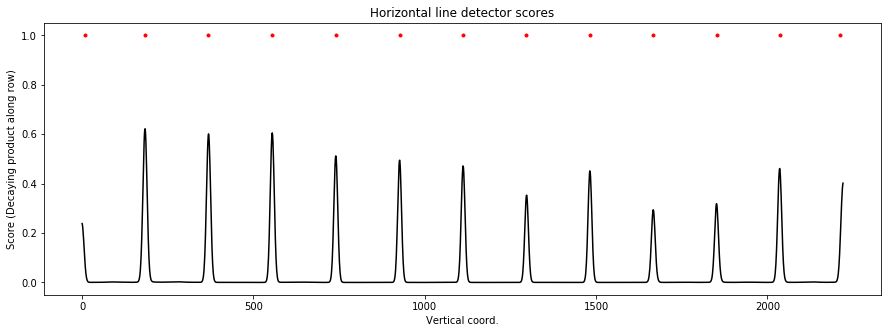

In [92]:
f, ax = plt.subplots(1, 1, figsize = (15, 5))

v_peak_ix = col_ix
h_peak_ix = row_ix

ax.plot(np.arange(img.shape[0]), hor_line_score, color = 'black')
ax.plot(h_peak_ix, [1]*h_peak_ix.shape[0], 'r.')
ax.set_title('Horizontal line detector scores'); 
ax.set_xlabel('Vertical coord.');
ax.set_ylabel('Score (Decaying product along row)');
plt.savefig('panel_extractor_line_detector.pdf')

The red points correspond to the indices at which the detector has been triggered.

In [ ]:
# Hough transform
# Define a range of angles, radii
# For each angle, define a vector (cos(theta), sin(theta))

# Procedure:
# Iterate over image. At each pixel;
#   > Form a vector (x, y)
#   > Take the dot product of this vector with all angles. (Result is point projection distance from center)
#   > Add to bins

# We can do the above simultaneously:
#  > Form a matrix C of coordinates (x, y) for all pixels.
#  > Let the Hough vector be u = (cos(theta), sin(theta)).
#  > Drop all zero pixels to form C'.
#  > Compute C'u = r, where r is a vector of project distances from the origin

# We can generalize the above further by letting U = [u1, u2, ..., un] where n is the number of angular bins.
# Then: C'U = R, such that R = [r1, r2, ..., rn] where ri is a vector of projection distances at angle i.